In [2]:
# %load https://gist.githubusercontent.com/eteq/19bae95cf6b30cd8730067a759894e89/raw/nb_defaults.py
import numpy as np

import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time

first = lambda x:next(iter(x))

%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
bmore = EarthLocation.of_address('Baltimore, MD')
mn = EarthLocation.of_address('Eagan, MN')
det = EarthLocation.of_address('Detroit, MI')
port = EarthLocation.of_address('Portland, OR')

In [5]:
approx = Time('2017-12-22')

In [6]:
def insolation(time, loc, extinction_coefficient=0):
    """
    negative insolation means below horizon
    """
    sunaa = get_sun(time).transform_to(AltAz(location=loc, obstime=time))
    flux_factor = (sunaa.distance**-2 * u.AU**2)
    airmass = sunaa.secz
    extinction = np.exp(-extinction_coefficient*(airmass - 1))
    return extinction*flux_factor.decompose()*np.sin(sunaa.alt)

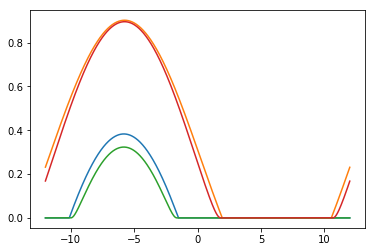

In [7]:
dt = np.linspace(-12, 12, 1000)*u.hour
t = approx + dt

plt.plot(dt, np.maximum(insolation(t, mn), 0))
plt.plot(dt, np.maximum(insolation(t+365//2*u.day, mn), 0))
plt.plot(dt, np.maximum(insolation(t, mn, .1), 0))
plt.plot(dt, np.maximum(insolation(t+365//2*u.day, mn, .1), 0))

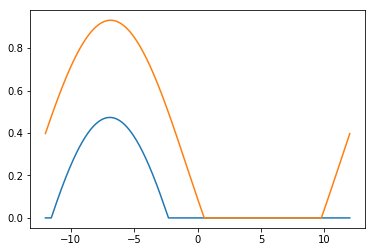

In [141]:
dt = np.linspace(-12, 12, 1000)*u.hour
t = approx + dt

plt.plot(dt, np.maximum(insolation(t, bmore), 0))
plt.plot(dt, np.maximum(insolation(t+365//2*u.day, bmore), 0))

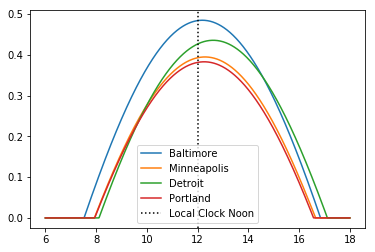

In [42]:
dt = np.linspace(6, 18, 1000)*u.hour
t = Time('2018-1-3 0:00') + dt

ecoeff = 0.

plt.plot(dt, np.maximum(insolation(t+5*u.hour, bmore, ecoeff), 0), label='Baltimore')
plt.plot(dt, np.maximum(insolation(t+6*u.hour, mn, ecoeff), 0), label='Minneapolis')
plt.plot(dt, np.maximum(insolation(t+5*u.hour, det, ecoeff), 0), label='Detroit')
plt.plot(dt, np.maximum(insolation(t+8*u.hour, port, ecoeff), 0), label='Portland')
plt.axvline(12, color='k', ls=':', label='Local Clock Noon')
plt.legend(loc=0)

In [276]:
dt = np.linspace(-12, 12, 1000)*u.hour
t1 = Time('2017-12-21') + dt 
t2 = Time('2017-6-21') + dt

ecoeff = .1

In [277]:
insols1 = []
lats = np.linspace(-90, 90, 101)[:-1]*u.deg
for lat in tqdm.tqdm_notebook(lats):
    loc = EarthLocation(lon=mn.lon, lat=lat)
    insols1.append(insolation(t1, loc, ecoeff))
insols1 = np.array(insols1)

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [278]:
insols2 = []
lats = np.linspace(-90, 90, 101)[:-1]*u.deg
for lat in tqdm.tqdm_notebook(lats):
    loc = EarthLocation(lon=mn.lon, lat=lat)
    insols2.append(insolation(t2, loc, ecoeff))
insols2 = np.array(insols2)

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


<Quantity [  0.,  9., 18., 27., 36., 45., 54., 63., 72., 81.] deg>

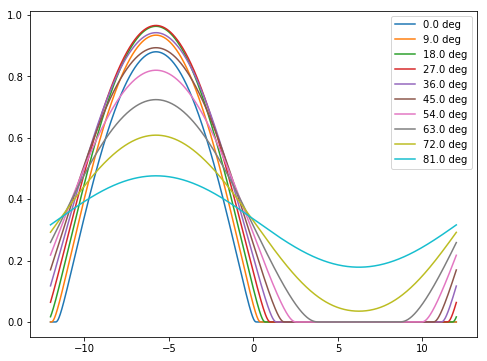

In [279]:
slc = slice(50, None, 5)

plt.figure(figsize=(8,6))
plt.plot(dt, np.maximum(insols2, 0)[slc].T)
plt.legend([l for l in lats[slc]])
lats[slc]

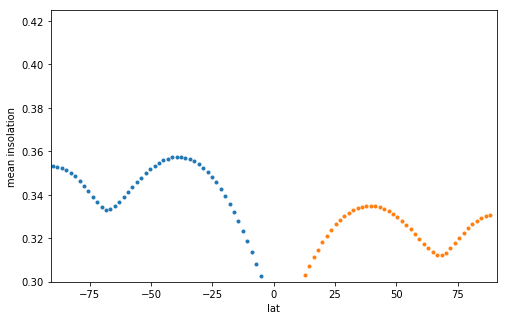

In [280]:
plt.figure(figsize=(8,5))
plt.plot(lats, np.mean(np.maximum(insols1, 0), axis=1), 'o', ms=3)
plt.plot(lats, np.mean(np.maximum(insols2, 0), axis=1), 'o', ms=3)

plt.xlim(-91, 91)
plt.ylim(.3, .425)
plt.xlabel('lat')
plt.ylabel('mean insolation')
None

## Varying atmospheric extinction 

In [298]:
insolss = {}
lats = np.linspace(0, 90, 50)*u.deg
coeffs = [0, .1, .2,.5, 1]
for ecoeff in tqdm.tqdm_notebook(coeffs):
    insolss[ecoeff] = []
    for lat in tqdm.tqdm_notebook(lats):
        loc = EarthLocation(lon=mn.lon, lat=lat)
        insolss[ecoeff].append(insolation(t2, loc, ecoeff))
    insolss[ecoeff] = np.array(insolss[ecoeff])

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


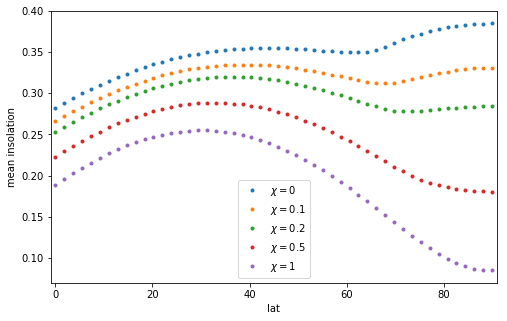

In [386]:
plt.figure(figsize=(8,5))

for ecoeff in coeffs:
    plt.plot(lats, np.mean(np.maximum(insolss[ecoeff], 0), axis=1), 'o', ms=3, label=r'$\chi = {}$'.format(ecoeff))

    plt.xlim(-1, 91)
    plt.xlabel('lat')
    plt.ylabel('mean insolation')
plt.legend(loc=0)

# Best insolation 

In [303]:
from scipy import optimize

In [368]:
def fopt(lat, time, lon, ecoeff):
    if not -90 <= lat <= 90:
        return 1
    loc = EarthLocation(lat=lat*u.deg, lon=lon)
    insols = np.maximum(insolation(t2, loc, extinction_coefficient=ecoeff), 0)
    return -np.mean(insols.value)

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


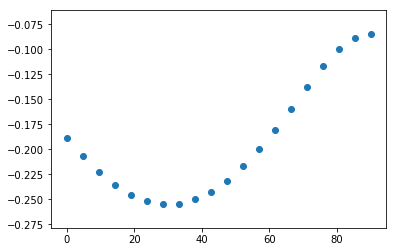

In [371]:
lats = np.linspace(0, 90, 20)

plt.scatter(lats, [fopt(lat, t2, mn.lon, 1) for lat in lats])

In [378]:
optimize.minimize_scalar(fopt, bounds=(-90, 90), args=(t2, mn.lon, 0))

     fun: -0.38505406297381622
    nfev: 38
     nit: 37
 success: True
       x: 89.999998571264982

In [379]:
optimize.minimize_scalar(fopt, bounds=(-90, 90), args=(t2, mn.lon, 0.1))

     fun: -0.33498285374854447
    nfev: 12
     nit: 11
 success: True
       x: 38.963086579210454

In [380]:
optimize.minimize_scalar(fopt, bounds=(-90, 90), args=(t2, mn.lon, 0.2))

     fun: -0.32010733819473208
    nfev: 10
     nit: 9
 success: True
       x: 36.586296027837541

In [381]:
optimize.minimize_scalar(fopt, bounds=(-90, 90), args=(t2, mn.lon, 0.5))

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


     fun: -0.28853979328681545
    nfev: 9
     nit: 8
 success: True
       x: 32.833560515336288

In [382]:
optimize.minimize_scalar(fopt, bounds=(-90, 90), args=(t2, mn.lon, 1))

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


     fun: -0.25497261432955026
    nfev: 12
     nit: 11
 success: True
       x: 30.014270817079034

In [414]:
from scipy import integrate

In [389]:
from astropy.modeling import models

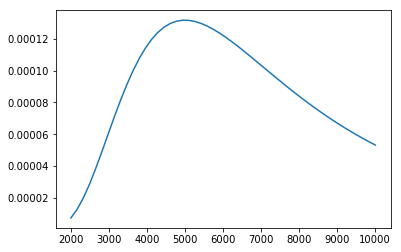

In [411]:
bb = models.BlackBody1D(5800*u.K)
wl = np.linspace(2000, 10000)*u.AA
plt.plot(wl, bb(wl).to(bb.bolometric_flux.unit/u.AA, u.spectral_density(wl)))

In [465]:
bbf = lambda wl: bb(wl*u.AA).to(bb.bolometric_flux.unit/u.AA, u.spectral_density(wl*u.AA)).value
integrate.quad(bbf, 10, 4000)[0], integrate.quad(bbf, 4000, 7000)[0], integrate.quad(bbf, 7000, 100000)[0]

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/modeling/blackbody.py:300: RuntimeWarning: overflow encountered in expm1
  boltzm1 = np.expm1(log_boltz)
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:1032: RuntimeWarning: overflow encountered in multiply
  return super(Quantity, self).__mul__(other)


(0.12399538254913679, 0.3676581915069935, 0.5076333227435966)

## Significant-length flights

In [59]:
import astroplan

In [84]:
def day_time(timenearset, locset, locrise):
    sset = astroplan.Observer(locset).sun_set_time(timenearset, which='nearest')
    srise = astroplan.Observer(locrise).sun_rise_time(sset, which='previous')
    return (sset - srise).to(u.hour)

In [99]:
flightday = Time('2017-12-22')
days = flightday + np.arange(-2,3)*u.day

In [109]:
lengths = u.Quantity([day_time(t, mn, bmore) for t in days])
lengths

<Quantity [ 10.02346083, 10.02171004, 10.02118541, 10.02189031,
            10.02382736] h>

In [110]:
lengths = u.Quantity([day_time(t, bmore, bmore) for t in days])
lengths

<Quantity [ 9.23455524, 9.23297087, 9.23247474, 9.23306933, 9.23475638] h>

In [111]:
lengths = u.Quantity([day_time(t, mn, mn) for t in days])
lengths

<Quantity [ 8.60423144, 8.60228124, 8.60170082, 8.60249357, 8.60466225] h>

In [112]:
lengths = u.Quantity([day_time(t, det, det) for t in days])
lengths

<Quantity [ 8.90348587, 8.90166476, 8.90107115, 8.90170799, 8.90357753] h>